In [1]:
import gurobipy as grb
from gurobipy import GRB
import networkx as nx


In [2]:
import fio.arith

def layers(G:nx.DiGraph, A: set, B: set, params=None):

    if params is None:
        params = {}

    m = grb.Model()

    for k, v in params.items():
        m.setParam(k, v)

    n = len(G.nodes)

    l = m.addVars(G.nodes, name="l", vtype=GRB.INTEGER)

    r = m.addVars(G.edges, name="r", vtype=GRB.BINARY)

    H = m.addVar(name="H", vtype=GRB.INTEGER)

    for u, v in G.edges:
        m.addConstr(l[v] >= l[u] + 1 - n * r[u, v])
    
    for u in G.nodes:
        m.addConstr(l[u] <= H)
    
    m.setObjectiveN(H, 0, priority=1, name="minimize number of layers")
    m.setObjectiveN(sum(l[v] - l[u] for u, v in G.edges), 1, name="minimize edges length")
    m.setObjectiveN(sum(l[u] for u in A), 2, name="minimize position of elements in A")
    m.setObjectiveN(sum(-l[u] for u in B), 3, name="maximize position of elements in B")
    m.setObjectiveN(sum(r[e] for e in G.edges), 4, priority=1, name="minimize feedback arcs")

    m.setParam(GRB.Param.PoolSolutions, 100)
    

    m.optimize()

    print(sum(r[e].X for e in G.edges))
    

    return {u: fio.arith.float_to_frac(l[u].X) for u in G.nodes}, m.Work



In [3]:
# import random

# def layered_bipartite(l, w, p):
#     G = nx.DiGraph()

#     layers = []

#     for k in range(l):
#         layers.append({(k, i) for i in range(w)})
#         if k > 0:
#             G.add_edges_from((u, v) for u in layers[-2] for v in layers[-1] if random.random() < p)

#     G.add_nodes_from(set().union(*layers))

#     A = set().union(*layers[::2])
#     B = set().union(*layers[1::2])

#     to_remove = {u for u, d in G.degree if d == 0} # pyright: ignore[reportGeneralTypeIssues]

#     G.remove_nodes_from(to_remove)
#     A = A - to_remove
#     B = B - to_remove

#     return G, A, B



In [4]:
# import matplotlib.pyplot as plt
# import numpy as np

# def benchmark_work(
#     sizes,
#     density=0.15,
#     reps=3,
#     seed_base=0,
# ):
#     """
#     sizes: iterable of problem sizes (e.g. [10, 20, 30, ...])
#     density: parameter passed to layered_bipartite
#     reps: number of random instances per size to average over
#     """
#     avg_work = []
#     std_work = []

#     for idx, n in enumerate(sizes):
#         works = []
#         for r in range(reps):
#             # If layered_bipartite supports seeding, you can pass different seeds here
#             G, A, B = layered_bipartite(n, n, density)
#             _, w = layers(G, A, B, params={GRB.Param.OutputFlag: 0})
#             works.append(w)

#         avg = np.mean(works)
#         std = np.std(works)
#         avg_work.append(avg)
#         std_work.append(std)

#         print(f"n={n:4d}  avg work={avg:.2f}  std={std:.2f}")

#     return np.array(sizes), np.array(avg_work), np.array(std_work)

# # Example usage
# sizes = list(range(10, 151, 10))  # 10,20,...,100
# sizes_arr, work_arr, work_std = benchmark_work(sizes, density=0.15, reps=3)

# plt.figure(figsize=(6, 4))
# plt.errorbar(sizes_arr, work_arr, yerr=work_std, fmt="o-", capsize=3)
# plt.xlabel("Problem size n (parameter of layered_bipartite)")
# plt.ylabel("Gurobi work (deterministic units)")
# plt.title("Scaling of MILP work with instance size")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [5]:
import json

space_age = json.load(open("data/space-age.json"))



In [6]:
G = nx.DiGraph()

for _, r in space_age["recipe"].items():
    if "ingredients" in r and ("category" not in r or r["category"] != "recycling") and ("subgroup" not in r or r["subgroup"] not in ["empty-barrel", "fill-barrel"]) :
        for i in r["ingredients"]:
            G.add_edge( f"item-{i['name']}", f"recipe-{r['name']}")
        for p in r["results"]:
            G.add_edge(f"recipe-{r['name']}", f"item-{p['name']}")

A = set()
B = set()
for u in G.nodes:
    if u.startswith("recipe-"):
        A.add(u)
    
    if u.startswith("item-"):
        B.add(u)

res, work = layers(G, A, B)

for u, l in res.items():
    G.nodes[u]["layer"] = l.numerator

Set parameter Username
Set parameter LicenseID to value 2732003
Academic license - for non-commercial use only - expires 2026-11-03
Set parameter PoolSolutions to value 100
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M4
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
PoolSolutions  100

Optimize a model with 1812 rows, 1813 columns and 4815 nonzeros
Model fingerprint: 0xe62c951c
Variable types: 0 continuous, 1813 integer (1191 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+02]
  Objective range  [1e+00, 7e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 5 objectives (2 combined)...
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve...
------------

In [7]:
G1 = G.copy()

for u, v, data in G.edges(data=True):
    if G.nodes[v]["layer"] < G.nodes[u]["layer"]:
        G1.remove_edge(u, v)
        G1.add_edge(v, u, inv=True, **data)

H = G1.copy()

for u, v in G1.edges():
    if (G1.nodes[v]["layer"] - G1.nodes[u]["layer"]) > 1:
        H.remove_edge(u, v)
        dummies = []
        for l in range(G1.nodes[u]["layer"] + 1, G1.nodes[v]["layer"]):
            dummies.append(f"dummy-{l}-{u}--{v}")
            H.add_node(f"dummy-{l}-{u}--{v}", layer=l)
        nx.add_path(H, [u] + dummies + [v])

    if (G1.nodes[u]["layer"] - G1.nodes[v]["layer"]) >= 0:
        assert False


len(H.nodes)/len(G.nodes)

4.407407407407407

In [8]:
layers = {}
for v, data in H.nodes(data=True):
    r = data["layer"]
    layers.setdefault(r, []).append(v)
print({k:len(l) for k, l in sorted(layers.items())})

{0: 8, 1: 22, 2: 38, 3: 49, 4: 72, 5: 71, 6: 177, 7: 159, 8: 269, 9: 259, 10: 242, 11: 234, 12: 223, 13: 218, 14: 200, 15: 200, 16: 149, 17: 147}


In [9]:
import gurobipy as gp
from gurobipy import GRB


def optimize_mlcm_layer_orders(H, sweeps=1, params=None, model=None, pos_attr="mlcm_pos"):
    """
    In-place multi-layer crossing minimization (MLCM) by 2-layer exact subproblems.

    - H must be a NetworkX DiGraph (or Graph) with a node attribute 'layer' (int).
    - The function computes, for each layer r, an ordering of nodes in that layer
      and stores it in H.nodes[v][pos_attr] as an integer position (0,1,2,...).

    Strategy:
      * Work with consecutive layer pairs (r, r+1).
      * For each such pair, build an exact ILP where:
          - The order of layer r is FIXED (taken from current positions).
          - The order of layer r+1 is optimized to minimize crossings with r.
      * Crossings are encoded via linear weights on pairwise ordering vars
        (no crossing variables).
      * Repeat this sweep a few times (controlled by 'sweeps').

    Args:
        H        : NetworkX graph with node attribute 'layer'.
        sweeps   : int, number of up-sweeps over all consecutive layer pairs.
        params   : optional dict of Gurobi parameters, e.g. {"OutputFlag": 0}.
        model    : optional existing Gurobi Model to reuse (cleared and rebuilt).
        pos_attr : name of the node attribute where positions are stored.

    Returns:
        model    : the last Gurobi model built (useful for inspection / logging).
    """

    # ----------------------------------------------------------------------
    # 0. Collect layers and initialize a per-layer order
    # ----------------------------------------------------------------------
    # Map: layer -> list of nodes
    layers = {}
    for v, data in H.nodes(data=True):
        r = data["layer"]
        layers.setdefault(r, []).append(v)

    # Sorted list of layer indices
    layer_ids = sorted(layers.keys())

    # Initialize ordering per layer: either existing pos_attr or sorted by name
    layer_order = {}
    for r in layer_ids:
        nodes_r = layers[r]
        # If all nodes already have a position in pos_attr, use that
        if all(pos_attr in H.nodes[v] for v in nodes_r):
            layer_order[r] = sorted(nodes_r, key=lambda v: H.nodes[v][pos_attr])
        else:
            layer_order[r] = sorted(nodes_r, key=str)

    # ----------------------------------------------------------------------
    # Helper: build and solve exact 2-layer ILP between layer r and r+1
    # ----------------------------------------------------------------------
    def solve_two_layer_subproblem(r, model):
        """
        Given fixed top layer r order, optimize bottom layer r+1.
        Updates layer_order[r+1] in place.
        Returns the (possibly reused) model.
        """

        top_nodes = layer_order[r]
        bottom_nodes = layer_order[r + 1]

        # Edges from layer r to r+1
        edges = [(u, v) for (u, v) in H.edges()
                 if H.nodes[u]["layer"] == r and H.nodes[v]["layer"] == r + 1]

        if not edges:
            # Nothing to optimize
            return model

        # ------------------------------------------------------------------
        # (a) Prepare / reuse model
        # ------------------------------------------------------------------
        if model is None:
            model = gp.Model(f"TwoLayer_MLCM_r{r}")
        else:
            # Clear model content but keep the environment
            model.reset()
            model.remove(model.getConstrs())
            model.remove(model.getVars())
            model.update()
            model.setAttr("ModelName", f"TwoLayer_MLCM_r{r}")

        # Apply user params if given
        if params is not None:
            for k, v in params.items():
                model.setParam(k, v)

        # ------------------------------------------------------------------
        # (b) Precompute positions and adjacency
        # ------------------------------------------------------------------
        # Fixed positions of top layer
        pos_top = {node: idx for idx, node in enumerate(top_nodes)}

        # For each bottom node j, list of neighbors i in top layer
        neigh_top = {j: [] for j in bottom_nodes}
        for (i, j) in edges:
            if j in neigh_top:
                neigh_top[j].append(i)

        # ------------------------------------------------------------------
        # (c) Index set for ordering variables y[j,l] (j<l in bottom layer)
        # ------------------------------------------------------------------
        Y_index = []
        for a in range(len(bottom_nodes)):
            j = bottom_nodes[a]
            for b in range(a + 1, len(bottom_nodes)):
                l = bottom_nodes[b]
                Y_index.append((j, l))

        # ------------------------------------------------------------------
        # (d) Compute weights for each (j,l)
        # ------------------------------------------------------------------
        # For each pair of bottom nodes (j,l), weight w[j,l] is:
        #
        #   w[j,l] = (#edge pairs (i in N(j), k in N(l)) with pos_top[i] > pos_top[k])
        #            - (#edge pairs (i in N(j), k in N(l)) with pos_top[i] < pos_top[k])
        #
        # Then total crossings = constant + sum_{j<l} w[j,l] * y[j,l].
        #
        weights = {}
        for (j, l) in Y_index:
            N_j = neigh_top[j]
            N_l = neigh_top[l]
            if not N_j or not N_l:
                weights[(j, l)] = 0
                continue

            w = 0
            for i in N_j:
                for k in N_l:
                    if i == k:
                        continue
                    if pos_top[i] < pos_top[k]:
                        # x_top = 1 => contributes -1
                        w -= 1
                    else:
                        # x_top = 0 => contributes +1
                        w += 1
            weights[(j, l)] = w

        # ------------------------------------------------------------------
        # (e) Variables: y[j,l] for j<l in bottom layer
        # ------------------------------------------------------------------
        # Index set is Y_index; objective is via obj=weights[(j,l)]
        obj_coeffs = [weights[(j, l)] for (j, l) in Y_index]
        y = model.addVars(
            Y_index,
            vtype=GRB.BINARY,
            obj=obj_coeffs,
            name="y",
        )

        # Helper to access y(j,l) for any distinct j,l
        def y_expr(j, l):
            if j == l:
                raise ValueError("y_expr called with identical nodes.")
            if (j, l) in y:
                return y[(j, l)]
            if (l, j) in y:
                return 1 - y[(l, j)]
            # In principle, this should not happen because Y_index is complete
            # over pairs; but we guard just in case.
            v_extra = model.addVar(vtype=GRB.BINARY, obj=0.0,
                                   name=f"y_extra_{j}_{l}")
            model.update()
            return v_extra

        # ------------------------------------------------------------------
        # (f) Transitivity constraints on bottom layer
        # ------------------------------------------------------------------
        # For all triples j<k<l:
        #   y_{j,k} + y_{k,l} - y_{j,l} <= 1
        # (Only upper bound needed for consistency.)
        for a in range(len(bottom_nodes)):
            j = bottom_nodes[a]
            for b in range(a + 1, len(bottom_nodes)):
                k = bottom_nodes[b]
                for c in range(b + 1, len(bottom_nodes)):
                    l = bottom_nodes[c]
                    model.addConstr(
                        y_expr(j, k) + y_expr(k, l) - y_expr(j, l) <= 1
                    )

        # ------------------------------------------------------------------
        # (g) Finalize and solve
        # ------------------------------------------------------------------
        model.ModelSense = GRB.MINIMIZE
        model.update()
        model.optimize()

        # ------------------------------------------------------------------
        # (h) Extract new order for bottom layer (if solved)
        # ------------------------------------------------------------------
        if model.Status in (GRB.OPTIMAL, GRB.SUBOPTIMAL):
            # Simple scoring: count how often each node appears "to the right"
            scores = {v: 0.0 for v in bottom_nodes}
            for (j, l) in Y_index:
                val = y[(j, l)].X
                # If y_{j,l} = 1, j is left of l → j smaller, l larger
                scores[j] += (1.0 - val)
                scores[l] += val
            new_order = sorted(bottom_nodes, key=lambda v: scores[v])
            layer_order[r + 1] = new_order
        # else: keep previous order

        return model

    # ----------------------------------------------------------------------
    # Main sweeps
    # ----------------------------------------------------------------------
    for _ in range(sweeps):
        for idx in range(len(layer_ids) - 1):
            r = layer_ids[idx]
            model = solve_two_layer_subproblem(r, model)

    # ----------------------------------------------------------------------
    # Write final positions back into H (in-place)
    # ----------------------------------------------------------------------
    for r in layer_ids:
        nodes_r = layer_order[r]
        for pos, v in enumerate(nodes_r):
            H.nodes[v][pos_attr] = pos

    return model

model = optimize_mlcm_layer_orders(H, sweeps=1)

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M4
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 1540 rows, 231 columns and 4620 nonzeros
Model fingerprint: 0x9066ecdc
Variable types: 0 continuous, 231 integer (231 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -76.0000000

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 10 available processors)

Solution count 1: -76 
No other solutions better than -76

Optimal solution found (tolerance 1.00e-04)
Best objective -7.600000000000e+01, best bound -7.600000000000e+01, gap 0.0000%
Discarded solution information
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M4
Thread count: 10

In [10]:
H.nodes(data=True)

NodeDataView({'item-advanced-circuit': {'layer': 11, 'mlcm_pos': 64}, 'recipe-speed-module': {'layer': 12, 'mlcm_pos': 142}, 'item-electronic-circuit': {'layer': 7, 'mlcm_pos': 92}, 'item-speed-module': {'layer': 13, 'mlcm_pos': 139}, 'recipe-speed-module-2': {'layer': 14, 'mlcm_pos': 46}, 'item-processing-unit': {'layer': 13, 'mlcm_pos': 20}, 'item-speed-module-2': {'layer': 15, 'mlcm_pos': 47}, 'recipe-speed-module-3': {'layer': 16, 'mlcm_pos': 11}, 'item-tungsten-carbide': {'layer': 13, 'mlcm_pos': 11}, 'item-speed-module-3': {'layer': 17, 'mlcm_pos': 9}, 'recipe-productivity-module': {'layer': 12, 'mlcm_pos': 157}, 'item-productivity-module': {'layer': 13, 'mlcm_pos': 154}, 'recipe-productivity-module-2': {'layer': 14, 'mlcm_pos': 51}, 'item-productivity-module-2': {'layer': 15, 'mlcm_pos': 52}, 'recipe-productivity-module-3': {'layer': 16, 'mlcm_pos': 28}, 'item-biter-egg': {'layer': 5, 'mlcm_pos': 62}, 'item-productivity-module-3': {'layer': 17, 'mlcm_pos': 26}, 'recipe-efficienc

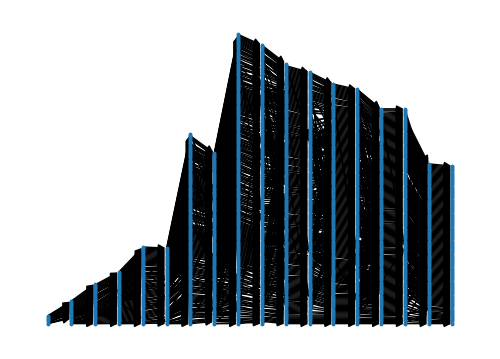

In [11]:
import numpy as np

pos = {u: np.array([data["layer"], 5*data["mlcm_pos"]]) for u, data in H.nodes(data=True)}

nx.draw(H, pos, node_size=3)

In [12]:
import fio.layout

def route_edges(H: nx.DiGraph,
                layer_attr: str = "layer",
                pos_attr: str = "mlcm_pos",
                channel_attr: str = "channel",
                params=None):
    """
    In-place edge routing using the feedback-arc layering idea.

    For each pair of consecutive layers r, r+1:
      - build an alternative graph G_alt whose nodes are edges (u,v) with
        u in layer r and v in layer r+1,
      - add a directed arc between two edges if they cross (straight segments),
        oriented from "left" edge to "right" edge (by midpoint),
      - run compute_layers(G_alt, set(), set(), params),
      - use the resulting layer l[e] as the channel index for edge e in H.

    This sets H[u][v][channel_attr] for all edges.
    """
    if params is None:
        params = {}

    # Build layer -> node list
    layers = {}
    for u, data in H.nodes(data=True):
        r = data[layer_attr]
        layers.setdefault(r, []).append(u)

    layer_ids = sorted(layers.keys())

    # Helper: do two edges cross when drawn straight in (layer, pos_attr) space?
    def edges_cross(e1, e2):
        u1, v1 = e1
        u2, v2 = e2
        x_u1 = H.nodes[u1][pos_attr]
        x_v1 = H.nodes[v1][pos_attr]
        x_u2 = H.nodes[u2][pos_attr]
        x_v2 = H.nodes[v2][pos_attr]
        # classic bipartite crossing test
        return (x_u1 - x_u2) * (x_v1 - x_v2) < 0

    # Loop on consecutive layers
    for idx in range(len(layer_ids) - 1):
        r = layer_ids[idx]
        r_next = layer_ids[idx + 1]

        # all edges between r and r+1
        E_r = [(u, v) for (u, v) in H.edges()
               if H.nodes[u][layer_attr] == r and H.nodes[v][layer_attr] == r_next]

        if len(E_r) == 0:
            continue

        if len(E_r) == 1:
            u, v = E_r[0]
            H.edges[u, v][channel_attr] = 0
            continue

        # Build alternative graph
        G_alt = nx.DiGraph()
        for e in E_r:
            G_alt.add_node(e)

        # Add preference arcs for crossing edges
        for i in range(len(E_r)):
            e1 = E_r[i]
            u1, v1 = e1
            x_u1 = H.nodes[u1][pos_attr]
            x_v1 = H.nodes[v1][pos_attr]
            mid1 = 0.5 * (x_u1 + x_v1)

            for j in range(i + 1, len(E_r)):
                e2 = E_r[j]
                if not edges_cross(e1, e2):
                    continue

                u2, v2 = e2
                x_u2 = H.nodes[u2][pos_attr]
                x_v2 = H.nodes[v2][pos_attr]
                mid2 = 0.5 * (x_u2 + x_v2)

                # simpler: left edge over right edge
                if mid1 < mid2:
                    G_alt.add_edge(e1, e2)
                else:
                    G_alt.add_edge(e2, e1)

        # If no arcs were added, no conflicts, put all in channel 0
        if G_alt.number_of_edges() == 0:
            for (u, v) in E_r:
                H.edges[u, v][channel_attr] = 0
            continue

        # Run feedback-arc layering on G_alt
        l_edges, _ = fio.layout.compute_layers(G_alt, A=set(), B=set(), params=params)

        # Normalize so minimum channel is 0
        min_layer = min(l_edges.values())
        for e in G_alt.nodes():
            chan = l_edges[e] - min_layer
            u, v = e
            H.edges[u, v][channel_attr] = int(chan)



route_edges(H, layer_attr="layer", pos_attr="mlcm_pos", channel_attr="channel", params={GRB.Param.MIPGap:0.5, GRB.Param.WorkLimit: 10})

Set parameter MIPGap to value 0.5
Set parameter WorkLimit to value 10
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M4
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
WorkLimit  10
MIPGap  0.5

Optimize a model with 27 rows, 28 columns and 64 nonzeros
Model fingerprint: 0x01606740
Variable types: 0 continuous, 28 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 5 objectives (2 combined)...
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve...
---------------------------------------------------------------------------

Presolve time: 0.00s
Presolved: 27 rows, 

In [13]:
H.edges(data=True)

OutEdgeDataView([('item-advanced-circuit', 'recipe-speed-module', {'channel': 73}), ('item-advanced-circuit', 'recipe-productivity-module', {'channel': 87}), ('item-advanced-circuit', 'recipe-efficiency-module', {'channel': 85}), ('item-advanced-circuit', 'recipe-bulk-inserter', {'channel': 91}), ('item-advanced-circuit', 'recipe-night-vision-equipment', {'channel': 16}), ('item-advanced-circuit', 'recipe-belt-immunity-equipment', {'channel': 27}), ('item-advanced-circuit', 'recipe-energy-shield-equipment', {'channel': 23}), ('item-advanced-circuit', 'recipe-solar-panel-equipment', {'channel': 23}), ('item-advanced-circuit', 'recipe-personal-roboport-equipment', {'channel': 33}), ('item-advanced-circuit', 'recipe-selector-combinator', {'channel': 110}), ('item-advanced-circuit', 'recipe-distractor-capsule', {'channel': 44}), ('item-advanced-circuit', 'recipe-tank', {'channel': 36}), ('item-advanced-circuit', 'recipe-modular-armor', {'channel': 22}), ('item-advanced-circuit', 'recipe-ch

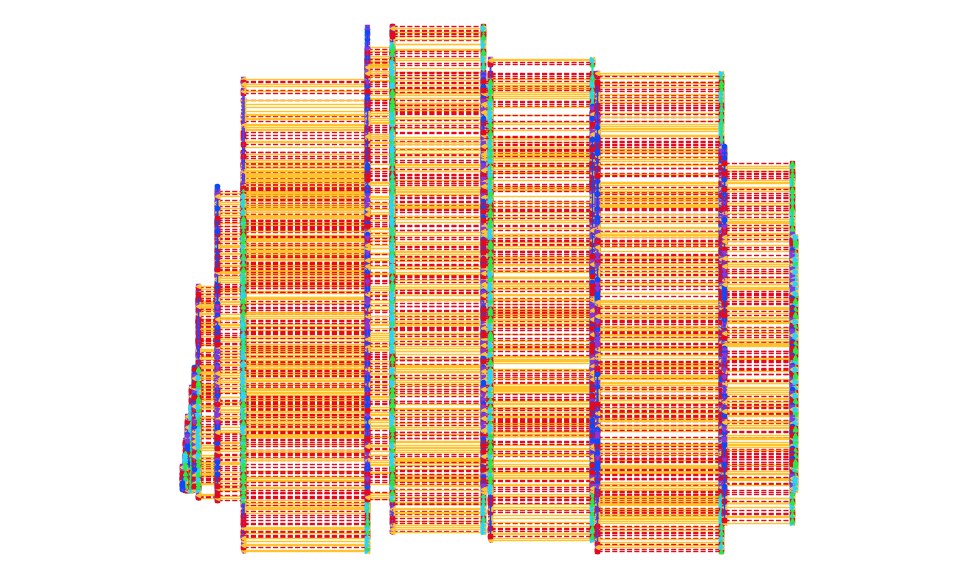

In [15]:
import matplotlib.pyplot as plt
from collections import defaultdict


def draw_routed(H,
                layer_attr="layer",
                pos_attr="mlcm_pos",
                channel_attr="channel",
                base_dx=1.0,
                dx_per_channel=0.3,
                y_scale=1.0,
                channel_gap=0.3,
                node_size=5,
                edge_width=1,
                figsize=(10, 6)):
    """
    Draw H with orthogonal routing, scaling layer distance with #channels.
    Assumes each node has `layer_attr` and `pos_attr`,
    and each edge has `channel_attr`.
    """

    # ---- 1) Layers and edges by layer pair ----
    layers = defaultdict(list)
    for u, d in H.nodes(data=True):
        layers[d[layer_attr]].append(u)
    layer_ids = sorted(layers.keys())

    edges_by_pair = defaultdict(list)  # r -> list of (u,v,chan)
    for u, v, ed in H.edges(data=True):
        ru = H.nodes[u][layer_attr]
        rv = H.nodes[v][layer_attr]
        if rv == ru + 1:
            edges_by_pair[ru].append((u, v, ed.get(channel_attr, 0)))

    # ---- 2) Compress channels and count per pair ----
    comp_edges = {}
    max_ch = {}
    for r, edges in edges_by_pair.items():
        chans = sorted({c for _, _, c in edges})
        if not chans:
            continue
        cmap = {c: i for i, c in enumerate(chans)}  # compress to 0..C-1
        comp_edges[r] = [(u, v, cmap[c]) for (u, v, c) in edges]
        max_ch[r] = len(chans)
    # layers without edges_between just won't affect spacing

    # ---- 3) X coordinate per layer, width depends on #channels ----
    x_layer = {}
    x = 0.0
    for i, r in enumerate(layer_ids):
        if i == 0:
            x_layer[r] = x
        else:
            prev = layer_ids[i - 1]
            C = max_ch.get(prev, 0)
            x += base_dx + dx_per_channel * max(0, C - 1)
            x_layer[r] = x

    # ---- 4) Node positions ----
    pos = {}
    for u, d in H.nodes(data=True):
        r = d[layer_attr]
        pos[u] = (x_layer[r], y_scale * d[pos_attr])

    # ---- 5) Plot ----
    fig, ax = plt.subplots(figsize=figsize)

    # nodes
    xs = [pos[u][0] for u in H.nodes]
    ys = [pos[u][1] for u in H.nodes]
    ax.scatter(xs, ys, s=node_size)

    # edges: 3 segments with channel-dependent y
    for r, edges in comp_edges.items():
        C = max_ch[r]
        for (u, v, ch) in edges:
            x_u, y_u = pos[u]
            x_v, y_v = pos[v]

            # center channels around the midpoint, evenly spaced
            y_mid = 0.5 * (y_u + y_v)
            y_chan = y_mid + (ch - (C - 1) / 2.0) * channel_gap

            ax.plot([x_u, x_u], [y_u, y_chan], linewidth=edge_width)
            ax.plot([x_u, x_v], [y_chan, y_chan], linewidth=edge_width)
            ax.plot([x_v, x_v], [y_chan, y_v], linewidth=edge_width)

    ax.set_aspect("equal", adjustable="datalim")
    ax.axis("off")
    plt.tight_layout()
    plt.show()

draw_routed(H)
